1 - Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

2 - Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

3 - Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

4 - (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

5 - (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], test_size=0.3, random_state=0)

In [4]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
#Список признаков
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [7]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [8]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

*RandomForestClassifier*

In [9]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [10]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [11]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.41, 0.23, 0.17, 0.05, 0.02, 0.75, 0.07, 0.09, 0.07, 0.88])

In [12]:
preds[:30]


array([0.41, 0.23, 0.17, 0.05, 0.02, 0.75, 0.07, 0.09, 0.07, 0.88, 0.03,
       0.15, 0.2 , 0.3 , 0.62, 0.32, 0.3 , 0.11, 0.19, 0.09, 0.42, 0.05,
       0.04, 0.13, 0.02, 0.17, 0.13, 0.02, 0.27, 0.36])

In [13]:
y_test

9394    0
898     1
2398    0
5906    0
2343    0
       ..
4004    0
7375    0
9307    0
8394    0
5233    1
Name: Exited, Length: 3000, dtype: int64

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.645, Precision=0.668, Recall=0.623


In [16]:
itog = pd.DataFrame({'metod': ['RandomForest'], 'Threshold': [thresholds[ix]],
                     'F-Score': [fscore[ix]],
                    'Precision': [precision[ix]],
                    'Recall': [recall[ix]]})
itog

,metod,Threshold,F-Score,Precision,Recall
0,RandomForest,0.38,0.645,0.668394,0.623188


*XGBoost*

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
classifier_gb = Pipeline([
    ('features',feats),
    ('classifier_gb', GradientBoostingClassifier(random_state = 42)),
])

In [19]:
#Обучение модели
classifier_gb.fit(X_train, y_train)
y_score = classifier_gb.predict_proba(X_test)[:, 1]


In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.302278, F-Score=0.646, Precision=0.619, Recall=0.675


In [21]:
itog = itog.append({'metod': 'XGBoost', 'Threshold': thresholds[ix],
                     'F-Score': fscore[ix],
                    'Precision': precision[ix],
                    'Recall': recall[ix]}, ignore_index=True)


itog

,metod,Threshold,F-Score,Precision,Recall
0,RandomForest,0.380000,0.645000,0.668394,0.623188
1,XGBoost,0.302278,0.645609,0.618907,0.674718


*Логистическая регрессия*

In [63]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X, y = make_classification(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [64]:
y_score = pipe.predict_proba(X_test)[:, 1]

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.612719, F-Score=1.000, Precision=1.000, Recall=1.000


In [66]:
itog = itog.append({'metod': 'LogReg', 'Threshold': thresholds[ix],
                     'F-Score': fscore[ix],
                    'Precision': precision[ix],
                    'Recall': recall[ix]}, ignore_index=True)


itog

,metod,Threshold,F-Score,Precision,Recall
0,RandomForest,0.380000,0.645000,0.668394,0.623188
1,XGBoost,0.302278,0.645609,0.618907,0.674718
2,LogReg,0.612719,1.000000,1.000000,1.000000


In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2089  290]
 [ 190  431]]


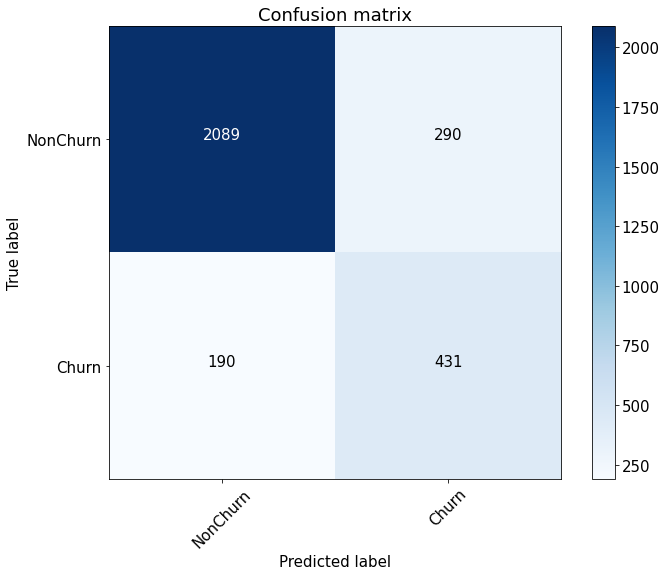

In [23]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Уклон в сторону False Negatives
Проведение компании по удержанию по всем клиентам не целесообразно, необходимое более точечная выборка выгодных клиентов.